In [1]:
!git clone -b mittra https://github.com/tirthankar95/CSCI_7000_FinalProject.git

fatal: destination path 'CSCI_7000_FinalProject' already exists and is not an empty directory.


In [2]:
import tensorflow as tf 
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
%cd /content/CSCI_7000_FinalProject/gym-minigrid/

/content/CSCI_7000_FinalProject/gym-minigrid


In [4]:
!pip install gym-minigrid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/CSCI_7000_FinalProject/gym-minigrid
  Attempting uninstall: gym-minigrid
    Found existing installation: gym-minigrid 0.0.5
    Can't uninstall 'gym-minigrid'. No files were found to uninstall.
  Running setup.py develop for gym-minigrid


In [6]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!python ./kerasDQN.py &> logs.txt

^C


In [8]:
import gym
import numpy as np
import random
import gym_minigrid
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential,Model
from keras.layers import LSTM,Bidirectional,Dense,Input,Embedding,TimeDistributed
from keras.callbacks import EarlyStopping, ModelCheckpoint
from gym_minigrid.envs.doorkey import *
from gym_minigrid.envs.crossing import *
from tqdm import tqdm
import math

num_actions=5
N_EXPERTS=2

In [9]:
def plotProgress(reward_plot):
    plt.plot(reward_plot)
    plt.xlabel('Episodes')
    plt.ylabel('Avg. reward')
    plt.title('Avg Reward Per Step V/S Episodes.')
    plt.show()

def create():
    global num_actions
    input=Input(shape=(3,147)) # (3,3,7,7) ~ the mini-grid by default returns (3,7,7) image.
    model=LSTM(units=64,return_sequences=False)(input)
    x1 = Dense(units=128, activation='relu')(model)
    x1 = Dense(units=64, activation='relu')(x1)
    x1 = Dense(units=32, activation='relu')(x1)
    x1 = Dense(units=16, activation='relu')(x1)
    output=Dense(units=num_actions,activation='linear')(x1)
    model=Model(input,output)
    return model

In [22]:
def updateNovice(novice,exp,wt_arr,lr):
  global N_EXPERTS
  m=novice.get_weights()
  wt=[]
  for xx in range(len(m)):
    temp=(1-lr)*novice.get_weights()[xx]
    for _ in range(N_EXPERTS):
      temp+=lr*np.array(exp[_].get_weights()[xx])*wt_arr[_]
    wt.append(temp)
  novice.set_weights(wt)

In [23]:
def mixed_algo():
  global N_EXPERTS,max_steps_per_episode,reward_plot,num_actions,env,novice,gamma
  frame_count=0
  mxFramesToPredict=3
  lr=1;trust_lr=0.1
  noOfEpisodes=100
  stepDecrease=noOfEpisodes
  
  # LOAD Experts
  normalize_Q=[[math.inf,-math.inf] for _ in range(N_EXPERTS)]
  exp=[]
  for _ in range(1,N_EXPERTS+1):
    temp_model=keras.models.load_model('Experts/Expert{}'.format(_))
    exp.append(temp_model)

  #Trust arrays.
  trust_arr=[1/N_EXPERTS for _ in range(1,1+N_EXPERTS)]
  trust_prob=[1/N_EXPERTS for _ in range(1,1+N_EXPERTS)]

  for _ in tqdm(range(noOfEpisodes)): 
    state = np.array(env.reset_m())
    episode_reward = 0
    frame_history=[]
    reward_history=[]
    wt_arr=[-1 for _ in range(N_EXPERTS)]; wt_arr_=[]
    q_arr=[-1 for _ in range(N_EXPERTS)]; q_arr_=[]
    frame_count=0
    for timestep in range(1, max_steps_per_episode):
      temp_state=dict(state.item(0)) # state is a 0-d numpy array.
      frame_history.append(temp_state['image'])
      frame_count+=1
      if frame_count<mxFramesToPredict:
        action = np.random.choice(num_actions)
      else:
        state_numpy = np.array(frame_history[-3:]).reshape(3,147)
        state_numpy = np.array([state_numpy])
        for __,e in enumerate(exp):
          action_probs = e(state_numpy, training=False)
          for A in action_probs[0]:
            normalize_Q[__][0]=min(normalize_Q[__][0],A)
            normalize_Q[__][1]=max(normalize_Q[__][1],A)
          trust=np.exp(trust_arr[__])/np.sum(np.exp(trust_arr))
          q_arr[__]=max((action_probs[0]-normalize_Q[__][0])/(normalize_Q[__][1]-normalize_Q[__][0])) # normalized Q value.
          action_P=q_arr[__]*trust
          wt_arr[__]=action_P # weights
        updateNovice(novice,exp,wt_arr,lr)
        lr=max(0.01,lr-1/(stepDecrease))
        action_probs = novice(state_numpy, training=False)
        action=np.argmax(action_probs[0])

      q_arr_.append(q_arr)
      wt_arr_.append(wt_arr)
      state_next, reward, done, _ = env.step_m(action)
      reward_history.append(reward)
      state_next = np.array(state_next)
      episode_reward += reward
      state=state_next

      if len(frame_history)>4:
        del frame_history[:1]
      if done:
        break

    reward_plot.append(episode_reward/timestep)
    rh_sz=len(reward_history)
    for i in range(1,rh_sz):
      reward_history[rh_sz-i-1]+=gamma*reward_history[rh_sz-i]
    print(wt_arr_)
    for _e_ in range(N_EXPERTS):
      for ___ in range(rh_sz):
        trust_arr[_e_]+=trust_lr*(reward_history[___]-q_arr_[___][_e_])*wt_arr_[___][_e_]
      trust_arr[_e_]/=rh_sz
    for _e_ in range(N_EXPERTS):   
      trust_prob[_e_]=np.exp(trust_arr[_e_])/np.sum(np.exp(trust_arr))
    if debug:
      print('See who you trust - ',trust_prob)

  plotProgress(reward_plot)
  novice.save('HotExpert.ml')

In [43]:
def og_algo():
  global max_steps_per_episode,reward_plot,num_actions,env,novice,novice_target,gamma
  epsilon = 1.0  # Epsilon greedy parameter
  epsilon_min = 0.1  # Minimum epsilon greedy parameter
  epsilon_max = 1.0  # Maximum epsilon greedy parameter
  epsilon_interval = (
      epsilon_max - epsilon_min
  )  # Rate at which to reduce chance of random action being taken
  batch_size = 4096  # Size of batch taken from replay buffer
  
  # Experience replay buffers
  action_history = []
  state_history = []
  state_next_history = []
  episode_reward_history=[]
  done_history = []
  rewards_history=[]

  model=novice
  model_target=novice_target
  loss_function = keras.losses.MeanSquaredError()
  optimizer=keras.optimizers.RMSprop()

  running_reward = 0
  episode_count = 0
  frame_count = 0

  # Number of frames to take random action and observe output
  epsilon_random_frames = 25000 #beast 50000
  # Number of frames for exploration
  epsilon_greedy_frames = 1000000.0
  # Maximum replay length
  # Note: The Deepmind paper suggests 1000000 however this causes memory issues
  max_memory_length = 100000
  # Train the model after 4 actions
  update_after_actions = 10
  # How often to update the target network
  update_target_network = 10000
  # Using huber loss for stability
  # We are taking 3 frames in our LSTM
  frame_offset=2

  noOfEpisodes=900 #beast 100000
  for _ in tqdm(range(noOfEpisodes)):
      state = np.array(env.reset_m())
      episode_reward = 0

      for timestep in range(1, max_steps_per_episode):
          # env.render(); Adding this line would show the attempts
          # of the agent in a pop up window.
          frame_count += 1

          # Use epsilon-greedy for exploration
          if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
              # Take random action
              action = np.random.choice(num_actions)
          else:
              # Predict action Q-values
              # From environment state
              state_numpy = np.array(state_history[-3:]).reshape(3,147)
              state_numpy = np.array([state_numpy])
              action_probs = model(state_numpy, training=False)
              # Take best action
              action = np.argmax(action_probs[0])

          # Decay probability of taking random action
          epsilon -= epsilon_interval / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min)

          # Apply the sampled action in our environment
          state_next, reward, done, _ = env.step_m(action)
          state_next = np.array(state_next)

          episode_reward += reward

          # Save actions and states in replay buffer
          action_history.append(action)
          temp_state=dict(state.item(0)) # state is a 0-d numpy array.
          state_history.append(temp_state['image'])
          temp_state=dict(state_next.item(0)) # state is a 0-d numpy array.
          state_next_history.append(temp_state['image'])
          done_history.append(done)
          rewards_history.append(reward)
          state = state_next

          # Update every fourth frame and once batch size is over 32
          if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
              # Get indices of samples for replay buffers
              indices = np.random.choice(range(len(done_history)-frame_offset), size=batch_size)+frame_offset
              i=indices[0]
              # Using list comprehension to sample from replay buffer
              state_sample = np.array([ np.array(state_history[i-frame_offset:i+1]).reshape(3,147) for i in indices])
              state_next_sample = np.array([ np.array(state_next_history[i-frame_offset:i+1]).reshape(3,147) for i in indices])
              rewards_sample = [rewards_history[i] for i in indices]
              action_sample = [action_history[i] for i in indices]
              # Build the updated Q-values for the sampled future states
              # Use the target model for stability
              future_rewards = model_target.predict(state_next_sample,verbose=False)
              # Q value = reward + discount factor * expected future reward
              updated_q_values = rewards_sample + gamma * np.max(\
                  future_rewards, axis=1)
              updated_q_values = updated_q_values.astype('float32')
              # Create a mask so we only calculate loss on the updated Q-values
              masks = tf.one_hot(action_sample, num_actions)
              with tf.GradientTape() as tape:    
                  q_values = model(state_sample)
                  # Apply the masks to the Q-values to get the Q-value for action taken
                  q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                  loss = loss_function(updated_q_values,q_action)
              # Backpropagation
              grads = tape.gradient(loss, model.trainable_variables)
              optimizer.apply_gradients(zip(grads, model.trainable_variables))
              

          if frame_count % update_target_network == 0:
              model.save('Expert1.ml')
              # update the the target network with new weights
              model_target.set_weights(model.get_weights())
              # Log details
              template = "running reward: {:.2f} at episode {}, frame count {}"
              print(template.format(running_reward, episode_count, frame_count))

          # Limit the state and reward history
          if len(rewards_history) > max_memory_length:
              del rewards_history[:1]
              del state_history[:1]
              del state_next_history[:1]
              del action_history[:1]
              del done_history[:1]
          if done:
              break

  # Update running reward to check condition for solving
      episode_reward_history.append(episode_reward)
      running_reward = np.mean(episode_reward_history)
      reward_plot.append(episode_reward/timestep)
      episode_count += 1
  plotProgress(reward_plot)

  model.save('Expert.ml')

  1%|          | 1/100 [00:01<02:04,  1.25s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.5>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.5>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.5>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.5>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.5>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.5>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.5>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.5>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.5>, 0]]
See who you trust -  [0.3956813, 0.60431874]


  2%|▏         | 2/100 [00:02<02:01,  1.24s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.1281944>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1281944>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1281944>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1281944>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1281944>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1281944>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1281944>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1281944>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1281944>, 0]]
See who you trust -  [0.47020462, 0.5297954]


  3%|▎         | 3/100 [00:03<02:02,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.1402986>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1402986>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1402986>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1402986>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1402986>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1402986>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1402986>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1402986>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1402986>, 0]]
See who you trust -  [0.4785743, 0.5214257]


  4%|▍         | 4/100 [00:05<02:00,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.11302304>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11302304>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11302304>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11302304>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11302304>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11302304>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11302304>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11302304>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11302304>, 0]]
See who you trust -  [0.48194498, 0.518055]


  5%|▌         | 5/100 [00:06<01:59,  1.25s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.113819085>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.113819085>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.113819085>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.113819085>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.113819085>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.113819085>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.113819085>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.113819085>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.113819085>, 0]]
See who you trust -  [0.4822093, 0.51779073]


  6%|▌         | 6/100 [00:07<01:56,  1.24s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.1562281>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1562281>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1562281>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1562281>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1562281>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1562281>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1562281>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1562281>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1562281>, 0]]
See who you trust -  [0.4725776, 0.5274224]


  7%|▋         | 7/100 [00:08<01:54,  1.24s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.11160683>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11160683>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11160683>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11160683>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11160683>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11160683>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11160683>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11160683>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11160683>, 0]]
See who you trust -  [0.48024833, 0.51975167]


  8%|▊         | 8/100 [00:09<01:53,  1.24s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15559277>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15559277>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15559277>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15559277>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15559277>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15559277>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15559277>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15559277>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15559277>, 0]]
See who you trust -  [0.4741872, 0.5258128]


  9%|▉         | 9/100 [00:11<01:53,  1.24s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.17676419>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17676419>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17676419>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17676419>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17676419>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17676419>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17676419>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17676419>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17676419>, 0]]
See who you trust -  [0.47398904, 0.52601093]


 10%|█         | 10/100 [00:12<01:51,  1.24s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15668258>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15668258>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15668258>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15668258>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15668258>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15668258>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15668258>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15668258>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15668258>, 0]]
See who you trust -  [0.47502032, 0.5249797]


 11%|█         | 11/100 [00:13<01:52,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.17707476>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17707476>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17707476>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17707476>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17707476>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17707476>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17707476>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17707476>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17707476>, 0]]
See who you trust -  [0.474041, 0.52595896]


 12%|█▏        | 12/100 [00:15<01:50,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15669975>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15669975>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15669975>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15669975>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15669975>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15669975>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15669975>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15669975>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15669975>, 0]]
See who you trust -  [0.47156873, 0.5284313]


 13%|█▎        | 13/100 [00:16<01:49,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15588252>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15588252>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15588252>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15588252>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15588252>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15588252>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15588252>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15588252>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15588252>, 0]]
See who you trust -  [0.47142705, 0.5285729]


 14%|█▍        | 14/100 [00:17<01:47,  1.25s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.114838794>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.114838794>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.114838794>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.114838794>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.114838794>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.114838794>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.114838794>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.114838794>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.114838794>, 0]]
See who you trust -  [0.48087707, 0.5191229]


 15%|█▌        | 15/100 [00:18<01:46,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.179258>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.179258>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.179258>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.179258>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.179258>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.179258>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.179258>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.179258>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.179258>, 0]]
See who you trust -  [0.47241983, 0.52758014]


 16%|█▌        | 16/100 [00:20<01:45,  1.25s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15616386>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15616386>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15616386>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15616386>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15616386>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15616386>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15616386>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15616386>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15616386>, 0]]
See who you trust -  [0.47147584, 0.52852416]


 17%|█▋        | 17/100 [00:21<01:44,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15585181>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15585181>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15585181>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15585181>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15585181>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15585181>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15585181>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15585181>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15585181>, 0]]
See who you trust -  [0.47142172, 0.5285783]


 18%|█▊        | 18/100 [00:22<01:42,  1.25s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.11483749>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11483749>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11483749>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11483749>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11483749>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11483749>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11483749>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11483749>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11483749>, 0]]
See who you trust -  [0.4821509, 0.51784915]


 19%|█▉        | 19/100 [00:23<01:42,  1.27s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.16754079>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16754079>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16754079>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16754079>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16754079>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16754079>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16754079>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16754079>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16754079>, 0]]
See who you trust -  [0.4761847, 0.5238153]


 20%|██        | 20/100 [00:25<01:42,  1.28s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15740837>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15740837>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15740837>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15740837>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15740837>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15740837>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15740837>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15740837>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15740837>, 0]]
See who you trust -  [0.47690704, 0.523093]


 21%|██        | 21/100 [00:26<01:40,  1.27s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.11617371>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11617371>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11617371>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11617371>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11617371>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11617371>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11617371>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11617371>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11617371>, 0]]
See who you trust -  [0.4800255, 0.51997447]


 22%|██▏       | 22/100 [00:27<01:38,  1.27s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.11693336>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11693336>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11693336>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11693336>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11693336>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11693336>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11693336>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11693336>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11693336>, 0]]
See who you trust -  [0.4815428, 0.5184572]


 23%|██▎       | 23/100 [00:28<01:36,  1.25s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15917957>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15917957>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15917957>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15917957>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15917957>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15917957>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15917957>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15917957>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15917957>, 0]]
See who you trust -  [0.4719978, 0.5280022]


 24%|██▍       | 24/100 [00:30<01:36,  1.27s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.17594804>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17594804>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17594804>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17594804>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17594804>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17594804>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17594804>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17594804>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17594804>, 0]]
See who you trust -  [0.47190315, 0.52809685]


 25%|██▌       | 25/100 [00:31<01:34,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15599306>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15599306>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15599306>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15599306>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15599306>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15599306>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15599306>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15599306>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15599306>, 0]]
See who you trust -  [0.47317415, 0.52682585]


 26%|██▌       | 26/100 [00:32<01:33,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15641321>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15641321>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15641321>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15641321>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15641321>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15641321>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15641321>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15641321>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15641321>, 0]]
See who you trust -  [0.4749676, 0.52503234]


 27%|██▋       | 27/100 [00:33<01:32,  1.27s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15700606>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15700606>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15700606>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15700606>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15700606>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15700606>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15700606>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15700606>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15700606>, 0]]
See who you trust -  [0.476824, 0.5231761]


 28%|██▊       | 28/100 [00:35<01:30,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.17774712>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17774712>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17774712>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17774712>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17774712>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17774712>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17774712>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17774712>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17774712>, 0]]
See who you trust -  [0.47023547, 0.52976453]


 29%|██▉       | 29/100 [00:36<01:29,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15544179>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15544179>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15544179>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15544179>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15544179>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15544179>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15544179>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15544179>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15544179>, 0]]
See who you trust -  [0.4747776, 0.5252224]


 30%|███       | 30/100 [00:37<01:28,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.16497867>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16497867>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16497867>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16497867>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16497867>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16497867>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16497867>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16497867>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16497867>, 0]]
See who you trust -  [0.4756992, 0.5243009]


 31%|███       | 31/100 [00:38<01:26,  1.25s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15724789>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15724789>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15724789>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15724789>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15724789>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15724789>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15724789>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15724789>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15724789>, 0]]
See who you trust -  [0.4734056, 0.5265944]


 32%|███▏      | 32/100 [00:40<01:25,  1.25s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.115320764>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.115320764>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.115320764>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.115320764>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.115320764>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.115320764>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.115320764>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.115320764>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.115320764>, 0]]
See who you trust -  [0.47976384, 0.5202362]


 33%|███▎      | 33/100 [00:41<01:23,  1.24s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15859151>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15859151>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15859151>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15859151>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15859151>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15859151>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15859151>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15859151>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15859151>, 0]]
See who you trust -  [0.4771512, 0.5228488]


 34%|███▍      | 34/100 [00:42<01:21,  1.24s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15772787>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15772787>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15772787>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15772787>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15772787>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15772787>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15772787>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15772787>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15772787>, 0]]
See who you trust -  [0.47522447, 0.5247755]


 35%|███▌      | 35/100 [00:43<01:21,  1.25s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.17715086>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17715086>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17715086>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17715086>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17715086>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17715086>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17715086>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17715086>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17715086>, 0]]
See who you trust -  [0.47405377, 0.52594626]


 36%|███▌      | 36/100 [00:45<01:19,  1.24s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15670398>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15670398>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15670398>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15670398>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15670398>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15670398>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15670398>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15670398>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15670398>, 0]]
See who you trust -  [0.47676155, 0.5232384]


 37%|███▋      | 37/100 [00:46<01:18,  1.25s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.116138265>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.116138265>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.116138265>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.116138265>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.116138265>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.116138265>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.116138265>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.116138265>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.116138265>, 0]]
See who you trust -  [0.482579, 0.517421]


 38%|███▊      | 38/100 [00:47<01:17,  1.24s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15952209>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15952209>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15952209>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15952209>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15952209>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15952209>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15952209>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15952209>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15952209>, 0]]
See who you trust -  [0.472057, 0.52794296]


 39%|███▉      | 39/100 [00:48<01:16,  1.25s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15681031>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15681031>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15681031>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15681031>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15681031>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15681031>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15681031>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15681031>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15681031>, 0]]
See who you trust -  [0.47651938, 0.5234806]


 40%|████      | 40/100 [00:50<01:15,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.1783584>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1783584>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1783584>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1783584>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1783584>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1783584>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1783584>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1783584>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1783584>, 0]]
See who you trust -  [0.47403297, 0.525967]


 41%|████      | 41/100 [00:51<01:14,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.1574667>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1574667>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1574667>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1574667>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1574667>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1574667>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1574667>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1574667>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1574667>, 0]]
See who you trust -  [0.47665393, 0.52334607]


 42%|████▏     | 42/100 [00:52<01:12,  1.25s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.17840877>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17840877>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17840877>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17840877>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17840877>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17840877>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17840877>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17840877>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17840877>, 0]]
See who you trust -  [0.47010884, 0.52989113]


 43%|████▎     | 43/100 [00:54<01:13,  1.28s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15616316>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15616316>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15616316>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15616316>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15616316>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15616316>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15616316>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15616316>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15616316>, 0]]
See who you trust -  [0.47121283, 0.52878714]


 44%|████▍     | 44/100 [00:55<01:12,  1.29s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15652989>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15652989>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15652989>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15652989>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15652989>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15652989>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15652989>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15652989>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15652989>, 0]]
See who you trust -  [0.47127587, 0.52872413]


 45%|████▌     | 45/100 [00:56<01:10,  1.29s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.11566648>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11566648>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11566648>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11566648>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11566648>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11566648>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11566648>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11566648>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11566648>, 0]]
See who you trust -  [0.4820235, 0.51797646]


 46%|████▌     | 46/100 [00:57<01:10,  1.30s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.18041857>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18041857>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18041857>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18041857>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18041857>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18041857>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18041857>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18041857>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18041857>, 0]]
See who you trust -  [0.4703976, 0.5296024]


 47%|████▋     | 47/100 [00:59<01:08,  1.29s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.16420105>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16420105>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16420105>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16420105>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16420105>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16420105>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16420105>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16420105>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16420105>, 0]]
See who you trust -  [0.4753069, 0.5246931]


 48%|████▊     | 48/100 [01:00<01:07,  1.29s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15788987>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15788987>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15788987>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15788987>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15788987>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15788987>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15788987>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15788987>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15788987>, 0]]
See who you trust -  [0.47325823, 0.52674174]


 49%|████▉     | 49/100 [01:01<01:05,  1.29s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.11615301>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11615301>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11615301>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11615301>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11615301>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11615301>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11615301>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11615301>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11615301>, 0]]
See who you trust -  [0.48089322, 0.51910675]


 50%|█████     | 50/100 [01:03<01:04,  1.29s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.16786474>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16786474>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16786474>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16786474>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16786474>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16786474>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16786474>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16786474>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16786474>, 0]]
See who you trust -  [0.47599635, 0.5240037]


 51%|█████     | 51/100 [01:04<01:02,  1.28s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.1581189>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1581189>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1581189>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1581189>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1581189>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1581189>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1581189>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1581189>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1581189>, 0]]
See who you trust -  [0.47154856, 0.52845144]


 52%|█████▏    | 52/100 [01:05<01:01,  1.27s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15664141>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15664141>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15664141>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15664141>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15664141>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15664141>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15664141>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15664141>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15664141>, 0]]
See who you trust -  [0.47648478, 0.5235152]


 53%|█████▎    | 53/100 [01:07<01:06,  1.42s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15828115>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15828115>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15828115>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15828115>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15828115>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15828115>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15828115>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15828115>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15828115>, 0]]
See who you trust -  [0.47506616, 0.5249338]


 54%|█████▍    | 54/100 [01:09<01:09,  1.51s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.17781447>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17781447>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17781447>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17781447>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17781447>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17781447>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17781447>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17781447>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17781447>, 0]]
See who you trust -  [0.4700234, 0.52997667]


 55%|█████▌    | 55/100 [01:10<01:11,  1.58s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.115359075>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.115359075>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.115359075>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.115359075>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.115359075>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.115359075>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.115359075>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.115359075>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.115359075>, 0]]
See who you trust -  [0.48064336, 0.51935667]


 56%|█████▌    | 56/100 [01:12<01:05,  1.48s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.16777752>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16777752>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16777752>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16777752>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16777752>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16777752>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16777752>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16777752>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16777752>, 0]]
See who you trust -  [0.47597992, 0.5240201]


 57%|█████▋    | 57/100 [01:13<01:01,  1.43s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.1781565>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1781565>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1781565>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1781565>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1781565>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1781565>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1781565>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1781565>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1781565>, 0]]
See who you trust -  [0.4739995, 0.5260005]


 58%|█████▊    | 58/100 [01:14<00:57,  1.38s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.116334945>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.116334945>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.116334945>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.116334945>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.116334945>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.116334945>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.116334945>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.116334945>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.116334945>, 0]]
See who you trust -  [0.47967276, 0.5203272]


 59%|█████▉    | 59/100 [01:15<00:55,  1.35s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.11772735>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11772735>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11772735>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11772735>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11772735>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11772735>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11772735>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11772735>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11772735>, 0]]
See who you trust -  [0.48138803, 0.51861197]


 60%|██████    | 60/100 [01:17<00:52,  1.32s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.18018071>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18018071>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18018071>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18018071>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18018071>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18018071>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18018071>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18018071>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18018071>, 0]]
See who you trust -  [0.4723389, 0.5276611]


 61%|██████    | 61/100 [01:18<00:51,  1.31s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.17679368>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17679368>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17679368>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17679368>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17679368>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17679368>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17679368>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17679368>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17679368>, 0]]
See who you trust -  [0.46987644, 0.5301236]


 62%|██████▏   | 62/100 [01:19<00:49,  1.30s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15608597>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15608597>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15608597>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15608597>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15608597>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15608597>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15608597>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15608597>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15608597>, 0]]
See who you trust -  [0.4763708, 0.5236292]


 63%|██████▎   | 63/100 [01:21<00:47,  1.29s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.11691694>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11691694>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11691694>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11691694>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11691694>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11691694>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11691694>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11691694>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11691694>, 0]]
See who you trust -  [0.4798493, 0.52015066]


 64%|██████▍   | 64/100 [01:22<00:46,  1.28s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.1593988>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1593988>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1593988>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1593988>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1593988>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1593988>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1593988>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1593988>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1593988>, 0]]
See who you trust -  [0.4770495, 0.5229505]


 65%|██████▌   | 65/100 [01:23<00:44,  1.28s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15846874>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15846874>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15846874>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15846874>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15846874>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15846874>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15846874>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15846874>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15846874>, 0]]
See who you trust -  [0.47160855, 0.5283915]


 66%|██████▌   | 66/100 [01:24<00:43,  1.28s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15666135>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15666135>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15666135>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15666135>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15666135>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15666135>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15666135>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15666135>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15666135>, 0]]
See who you trust -  [0.47648886, 0.5235112]


 67%|██████▋   | 67/100 [01:26<00:42,  1.28s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.1582825>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1582825>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1582825>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1582825>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1582825>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1582825>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1582825>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1582825>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1582825>, 0]]
See who you trust -  [0.47682104, 0.52317894]


 68%|██████▊   | 68/100 [01:27<00:40,  1.27s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.17847131>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17847131>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17847131>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17847131>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17847131>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17847131>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17847131>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17847131>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17847131>, 0]]
See who you trust -  [0.47207448, 0.52792555]


 69%|██████▉   | 69/100 [01:28<00:39,  1.27s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15681611>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15681611>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15681611>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15681611>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15681611>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15681611>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15681611>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15681611>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15681611>, 0]]
See who you trust -  [0.47478232, 0.5252177]


 70%|███████   | 70/100 [01:29<00:37,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15771562>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15771562>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15771562>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15771562>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15771562>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15771562>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15771562>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15771562>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15771562>, 0]]
See who you trust -  [0.4714794, 0.52852064]


 71%|███████   | 71/100 [01:31<00:36,  1.27s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.16457868>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16457868>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16457868>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16457868>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16457868>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16457868>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16457868>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16457868>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16457868>, 0]]
See who you trust -  [0.47537807, 0.5246219]


 72%|███████▏  | 72/100 [01:32<00:35,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15791352>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15791352>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15791352>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15791352>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15791352>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15791352>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15791352>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15791352>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15791352>, 0]]
See who you trust -  [0.47326258, 0.52673745]


 73%|███████▎  | 73/100 [01:33<00:34,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.1771394>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1771394>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1771394>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1771394>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1771394>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1771394>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1771394>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1771394>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1771394>, 0]]
See who you trust -  [0.47383052, 0.5261695]


 74%|███████▍  | 74/100 [01:34<00:32,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.11629347>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11629347>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11629347>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11629347>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11629347>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11629347>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11629347>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11629347>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11629347>, 0]]
See who you trust -  [0.4822278, 0.51777214]


 75%|███████▌  | 75/100 [01:36<00:31,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.1601889>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1601889>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1601889>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1601889>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1601889>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1601889>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1601889>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1601889>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1601889>, 0]]
See who you trust -  [0.47190312, 0.5280969]


 76%|███████▌  | 76/100 [01:37<00:30,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.11582042>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11582042>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11582042>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11582042>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11582042>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11582042>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11582042>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11582042>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11582042>, 0]]
See who you trust -  [0.48078856, 0.5192114]


 77%|███████▋  | 77/100 [01:38<00:28,  1.25s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15971081>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15971081>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15971081>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15971081>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15971081>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15971081>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15971081>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15971081>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15971081>, 0]]
See who you trust -  [0.47182128, 0.52817875]


 78%|███████▊  | 78/100 [01:40<00:27,  1.27s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.16469802>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16469802>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16469802>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16469802>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16469802>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16469802>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16469802>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16469802>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.16469802>, 0]]
See who you trust -  [0.47540054, 0.5245995]


 79%|███████▉  | 79/100 [01:41<00:26,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.14589545>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.14589545>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.14589545>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.14589545>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.14589545>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.14589545>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.14589545>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.14589545>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.14589545>, 0]]
See who you trust -  [0.4783996, 0.52160037]


 80%|████████  | 80/100 [01:42<00:25,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.17906216>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17906216>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17906216>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17906216>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17906216>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17906216>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17906216>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17906216>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17906216>, 0]]
See who you trust -  [0.4702028, 0.52979726]


 81%|████████  | 81/100 [01:43<00:24,  1.27s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.11540311>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11540311>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11540311>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11540311>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11540311>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11540311>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11540311>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11540311>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11540311>, 0]]
See who you trust -  [0.48193765, 0.5180623]


 82%|████████▏ | 82/100 [01:45<00:22,  1.27s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.11828323>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11828323>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11828323>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11828323>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11828323>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11828323>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11828323>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11828323>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11828323>, 0]]
See who you trust -  [0.48026338, 0.5197366]


 83%|████████▎ | 83/100 [01:46<00:21,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15953635>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15953635>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15953635>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15953635>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15953635>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15953635>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15953635>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15953635>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15953635>, 0]]
See who you trust -  [0.47179142, 0.5282086]


 84%|████████▍ | 84/100 [01:47<00:20,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15672208>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15672208>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15672208>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15672208>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15672208>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15672208>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15672208>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15672208>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15672208>, 0]]
See who you trust -  [0.47650135, 0.5234987]


 85%|████████▌ | 85/100 [01:48<00:18,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.11694898>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11694898>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11694898>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11694898>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11694898>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11694898>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11694898>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11694898>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.11694898>, 0]]
See who you trust -  [0.48114347, 0.5188565]


 86%|████████▌ | 86/100 [01:50<00:17,  1.27s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.18008918>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18008918>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18008918>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18008918>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18008918>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18008918>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18008918>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18008918>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.18008918>, 0]]
See who you trust -  [0.47232476, 0.5276752]


 87%|████████▋ | 87/100 [01:51<00:16,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.17678839>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17678839>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17678839>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17678839>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17678839>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17678839>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17678839>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17678839>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17678839>, 0]]
See who you trust -  [0.46987563, 0.53012437]


 88%|████████▊ | 88/100 [01:52<00:15,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.17587169>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17587169>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17587169>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17587169>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17587169>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17587169>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17587169>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17587169>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17587169>, 0]]
See who you trust -  [0.46974352, 0.53025645]


 89%|████████▉ | 89/100 [01:53<00:13,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.1560418>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1560418>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1560418>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1560418>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1560418>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1560418>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1560418>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1560418>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1560418>, 0]]
See who you trust -  [0.4746321, 0.5253679]


 90%|█████████ | 90/100 [01:55<00:12,  1.27s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15766573>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15766573>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15766573>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15766573>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15766573>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15766573>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15766573>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15766573>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15766573>, 0]]
See who you trust -  [0.47494698, 0.525053]


 91%|█████████ | 91/100 [01:56<00:11,  1.28s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15777032>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15777032>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15777032>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15777032>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15777032>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15777032>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15777032>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15777032>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15777032>, 0]]
See who you trust -  [0.47496724, 0.52503276]


 92%|█████████▏| 92/100 [01:57<00:10,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15777706>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15777706>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15777706>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15777706>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15777706>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15777706>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15777706>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15777706>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15777706>, 0]]
See who you trust -  [0.4714899, 0.5285101]


 93%|█████████▎| 93/100 [01:58<00:08,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15662193>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15662193>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15662193>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15662193>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15662193>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15662193>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15662193>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15662193>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15662193>, 0]]
See who you trust -  [0.47129166, 0.52870834]


 94%|█████████▍| 94/100 [02:00<00:07,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15655607>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15655607>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15655607>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15655607>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15655607>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15655607>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15655607>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15655607>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15655607>, 0]]
See who you trust -  [0.47646725, 0.52353275]


 95%|█████████▌| 95/100 [02:01<00:06,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15827534>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15827534>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15827534>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15827534>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15827534>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15827534>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15827534>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15827534>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15827534>, 0]]
See who you trust -  [0.47332865, 0.52667135]


 96%|█████████▌| 96/100 [02:02<00:05,  1.25s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.17716414>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17716414>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17716414>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17716414>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17716414>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17716414>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17716414>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17716414>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17716414>, 0]]
See who you trust -  [0.47187194, 0.528128]


 97%|█████████▋| 97/100 [02:03<00:03,  1.25s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.1766189>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1766189>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1766189>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1766189>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1766189>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1766189>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1766189>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1766189>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.1766189>, 0]]
See who you trust -  [0.47178742, 0.52821255]


 98%|█████████▊| 98/100 [02:05<00:02,  1.25s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.15672076>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15672076>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15672076>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15672076>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15672076>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15672076>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15672076>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15672076>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.15672076>, 0]]
See who you trust -  [0.47650102, 0.52349895]


 99%|█████████▉| 99/100 [02:06<00:01,  1.26s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.17835154>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17835154>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17835154>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17835154>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17835154>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17835154>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17835154>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17835154>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17835154>, 0]]
See who you trust -  [0.47403184, 0.52596813]


100%|██████████| 100/100 [02:07<00:00,  1.28s/it]

[[<tf.Tensor: shape=(), dtype=float32, numpy=0.17742734>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17742734>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17742734>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17742734>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17742734>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17742734>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17742734>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17742734>, 0], [<tf.Tensor: shape=(), dtype=float32, numpy=0.17742734>, 0]]
See who you trust -  [0.47387838, 0.5261216]


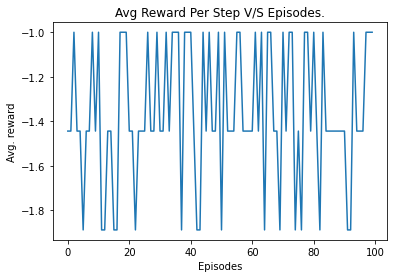

In [24]:
max_steps_per_episode = 10 # If the agent doesn't terminate normally we use this var to terminate
reward_plot=[]
seed = 42
env = DoorKeyEnv(size=6)
env.seed(seed)
novice=create()
novice_target=create()
loss_function = keras.losses.MeanSquaredError()
optimizer=keras.optimizers.RMSprop()
gamma = 0.99  # Discount factor for past rewards
debug=True

mixed_algo()
og_algo()

In [ ]:
from google.colab import drive,files
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!cp -rf Expert.ml /content/drive/MyDrive/SavedRLModels/

In [ ]:
!ls -lrt /content/drive/MyDrive/SavedRLModels/

total 725
drwx------ 2 root root   4096 Dec  3 21:50 variables
-rw------- 1 root root 720473 Dec  3 21:50 saved_model.pb
-rw------- 1 root root   8614 Dec  3 21:50 keras_metadata.pb
drwx------ 2 root root   4096 Dec  3 21:50 assets
drwx------ 4 root root   4096 Dec  3 21:51 Expert1.ml
